$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{University of Los Andes}$$
$$\textrm{High Energy Physics Group: Phenomenology of Particles}$$

This code was written to be running in Docker. If you do not have a Docker inside hep-server2 please refer to: https://github.com/Phenomenology-group-uniandes/Tutoriales_Generales

In [1]:
import os, sys

def add_parent_lib_path(name="Semanas_07_08_09"):
    sys.path.append(os.path.join(sys.path[0].split(name)[0],name))
    
add_parent_lib_path()

In [2]:
from Uniandes_Framework.ml_tools import tools
from Uniandes_Framework.delphes_reader import root_analysis

import pandas as pd

from ROOT import TCanvas #Permite poner los histogramas
from ROOT import THStack #Permite graficar varios histogramas al mismo tiempo
from ROOT import TLegend #Permite poner legends cuando se sobrelapan histogramas
from ROOT import TLatex #Permite poner avisos en Latex en las graficas

Welcome to JupyROOT 6.22/06


In [3]:
Path_Leptoquarks_searches = os.path.dirname(os.path.dirname(os.path.realpath('XBG_Discriminator_Histograms.ipynb')))

In [4]:
channels = ["hadronic_dLQ", "hadronic_sLQ", "hadronic_non-resonant", "semileptonic_dLQ", "semileptonic_sLQ", "semileptonic_non-resonant"]
signals = ['LQ_LQ', 'Tau_LQ', 'Tau_Tau']
Masses = ['1250', '1500', '1750', '2000', '2250', '2500']
bkgs = ['ttbar', 'z_jets', 'w_jets', 'stop','ww', 'wz', 'zz']

In [5]:
def Read_Cutflows_N_Events(channel, signal, Luminosity = 137*1000):

    cutflows_path = os.path.join(Path_Leptoquarks_searches, '03_delphes_preselection/Cutflows', f'{channel}.csv')
    cutflows_file = pd.read_csv(cutflows_path, index_col= 0)
    cutflows_file = cutflows_file.dropna()
    
    Efficience = cutflows_file[signal]['DeltaR > 0.3']/cutflows_file[signal]['All']
    XS = cutflows_file[signal]['XS']
    return Efficience*XS*Luminosity

In [6]:
histograms = {}
histograms_bkg = {}
histograms_signal = {}

In [7]:
for channel in channels:    
    histograms[channel] = {}
    histograms_bkg[channel] = {}
    histograms_signal[channel] = {}
    for Mass in Masses:
                
        path_root_file = os.path.join(f'{Path_Leptoquarks_searches}', '04_ML_Classification','Histograms', channel,f'M{Mass}', f'Histograms_M{Mass}_XGB.root')       
        histograms[channel][f'M{Mass}'] = root_analysis.Read_ROOT_File(path_root_file, expected_keys = [f"{signal}_{Mass}" for signal in signals] + bkgs)
        histograms_bkg[channel][f'M{Mass}'] = {}
        histograms_signal[channel][f'M{Mass}'] = {}        
        
        for signal_key in histograms[channel][f'M{Mass}'].keys():
            histo = histograms[channel][f'M{Mass}'][signal_key]
            N_events = Read_Cutflows_N_Events(channel, signal_key)
            histo.Scale(N_events/histo.Integral())
            if signal_key in bkgs: histograms_bkg[channel][f'M{Mass}'][signal_key] = histo
            for signal in signals:
                if signal in signal_key: histograms_signal[channel][f'M{Mass}'][signal] = histo
            
        N_events = Read_Cutflows_N_Events(channel, 'w_jets')
        h_w_jets = histograms[channel][f'M{Mass}']['z_jets'].Clone('')
        h_w_jets.SetDirectory(0)
        h_w_jets.Scale(N_events/h_w_jets.Integral())
        h_w_jets.SetNameTitle('w_jets', 'w_jets')
        
        histograms[channel][f'M{Mass}']['w_jets'] = h_w_jets
        histograms_bkg[channel][f'M{Mass}']['w_jets'] = h_w_jets

In [8]:
canvas = TCanvas("Canvas", " ", 600, 400)

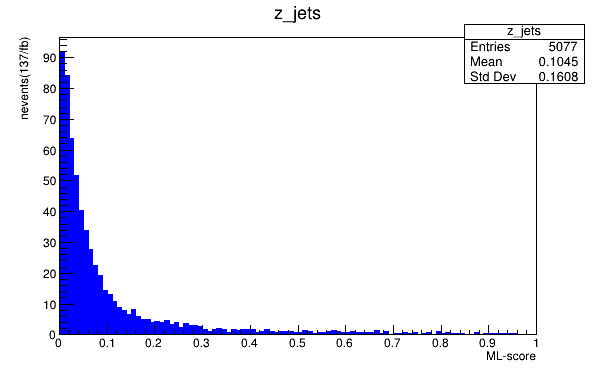

In [9]:
histograms_bkg['hadronic_dLQ']['M1250']['z_jets'].Draw('hist')
canvas.Draw()

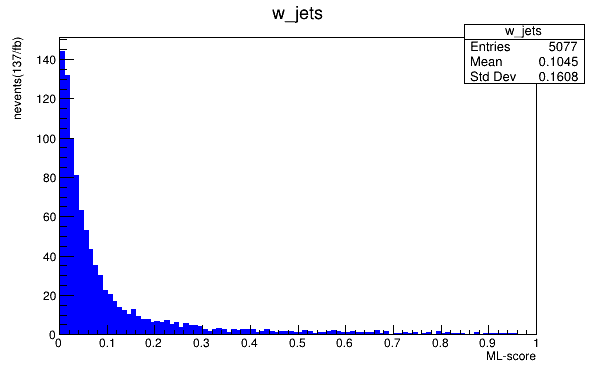

In [10]:
histograms_bkg['hadronic_dLQ']['M1250']['w_jets'].Draw('hist')
canvas.Draw()

In [11]:
histograms_bkg['hadronic_dLQ']['M1250'].keys()

dict_keys(['ttbar', 'z_jets', 'w_jets', 'stop', 'ww', 'wz', 'zz'])

In [12]:
histograms_signal['hadronic_dLQ']['M1250'].keys()

dict_keys(['LQ_LQ', 'Tau_LQ', 'Tau_Tau'])

In [13]:
def Overlap_Histos(Signal_Histogram_Dict, 
                   Bkg_Histogram_Dict, 
                   channel,
                   Signal_Directory, 
                   Bkg_Directory, 
                   Title_Plot, 
                   Mass, 
                   Signal_to_ignore = '', 
                   alpha_bkg = 0.05, 
                   alpha_signal = 0.05, 
                   Stack = False, 
                   Log_Y = False, 
                   Log_X = True, 
                   Grid = False,
                   Path_folder_to_save = ''):
    
    #if Stack is False -> Histograms will be normalized by A.U
    #if Stack is True -> Histograms will be normalized by number of physical events
    
    canvas = TCanvas(Title_Plot, " ", 0, 0, 1280, 720)
    
    #legend = TLegend(0.9,.4,1,.89) #Legend outside the graph
    legend = TLegend(0.48,.75,0.87,.89)
    legend.SetNColumns(4) 
    legend.SetHeader('Mass_{U}' + f'= {int(Mass)/1000} TeV' + ', g_{U} = 1.8' + ', #beta_{R}^{b #tau} = -1',"C")
    legend.SetLineWidth(1)
    #legend.SetFillStyle(0) #Transparent legend window
    
    x_axis = 'XGB-Output'
    
    Histos = THStack('hist', Title_Plot)
    
    Dict_Hist_to_save_keys = []
        
    for i in range(len(Bkg_Directory.keys())):
            bkg_key = list(Bkg_Directory.keys())[i]
            bkg_list = Bkg_Directory[bkg_key]
            Dict_Hist_to_save_keys.append(bkg_key)
            
            histo_list = []
            for bkg in bkg_list:
                if (bkg != Signal_to_ignore):
                    if (Bkg_Histogram_Dict[channel][f'M{Mass}'][bkg] != {}):
                        h = Bkg_Histogram_Dict[channel][f'M{Mass}'][bkg]
                        h.Scale(Read_Cutflows_N_Events(channel, bkg)/h.Integral())
                        histo_list.append(h)
                
            histo_Nevents = root_analysis.sum_histos(histo_list)
            histo_normalized = root_analysis.sum_histos(histo_list)
            histo_normalized.Scale(1.0/histo_normalized.Integral())
            
            if (Stack): 
                histo = histo_Nevents
                histo.SetTitle(f'{bkg_key}; {x_axis}; Events')
            else: 
                histo = histo_normalized
                histo.SetTitle(f'{bkg_key}; {x_axis}; A.U')
            
            color = len(Signal_Directory.keys()) + i + 1
            if color == 7: color = 3
            
            histo.SetLineColor(color)
            histo.SetFillColorAlpha(color, alpha_bkg)
            histo.SetLineWidth(2)
            histo.SetDirectory(0)     
            
            Histos.Add(histo)
            legend.AddEntry(histo,bkg_key)
            
    for j in range(len(Signal_Directory.keys())):
            signal_key = list(Signal_Directory.keys())[j]
            signal_list = Signal_Directory[signal_key]
            Dict_Hist_to_save_keys.append(signal_key)
            
            histo_list = []
            for signal in signal_list:
                if (signal != Signal_to_ignore):
                    if (Signal_Histogram_Dict[channel][f'M{Mass}'][signal] != {}):
                        h = Signal_Histogram_Dict[channel][f'M{Mass}'][signal]
                        h.Scale(Read_Cutflows_N_Events(channel, f'{signal}_{Mass}')/h.Integral())
                        histo_list.append(h)
                
            histo_Nevents = root_analysis.sum_histos(histo_list)
            
            histo_normalized = root_analysis.sum_histos(histo_list)
            histo_normalized.Scale(1.0/histo_normalized.Integral())
            
            if (Stack): 
                histo = histo_Nevents
                histo.SetTitle(f'{signal_key}; {x_axis}; Events')
            else: 
                histo = histo_normalized
                histo.SetTitle(f'{signal_key}; {x_axis}; A.U')
            
            color = j + 1
            if color == 3: color = 7
            
            histo.SetLineColor(color)
            histo.SetFillColorAlpha(color, alpha_signal)
            histo.SetLineStyle(2)
            histo.SetLineWidth(2)
            histo.SetDirectory(0)     
            
            Histos.Add(histo)
            legend.AddEntry(histo,signal_key)
            
    if Log_Y: canvas.SetLogy()
    if Log_X: canvas.SetLogx()
    if Grid: canvas.SetGrid()
        
    if Stack:
        Histos.Draw("hist")
        Histos.SetTitle(f'{Title_Plot}; {x_axis}; Events')  
        
    else: 
        Histos.Draw("histnostack")
        Histos.SetTitle(f'{Title_Plot}; {x_axis}; A.U')  
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.DrawLatex(0.76,0.91,'#sqrt{s} = 13 TeV')
    #latex.DrawLatex(0.61,0.91,'#sqrt{s} = 13 TeV, L = 137 fb^{-1}')

    canvas.Draw()
    legend.Draw('same')
    
    #Histos.GetXaxis().SetLimits(0.0, float(Mass)*3)  
    Dict_Hist = {}
    for i, histo in enumerate(Histos.GetHists()):
        histo.SetDirectory(0)
        Dict_Hist[Dict_Hist_to_save_keys[i]] = histo    
        
    
    if Path_folder_to_save != '':
        try: os.mkdir(Path_folder_to_save)
        except: pass

        with root_analysis.Quiet():
            root_analysis.Save_Histograms_png(Path_folder_to_save, Dict_Hist, Log_Y = True)
            root_analysis.Write_txt_file_with_high_per_bin(os.path.join(Path_folder_to_save, 'high_per_bin'), Dict_Hist)
            canvas.SaveAs(os.path.join(Path_folder_to_save, f'THStack_{channel}.png')) 
            
    Dict_Hist['THStack'] = Histos     
    
    return Histos, canvas, legend, Dict_Hist

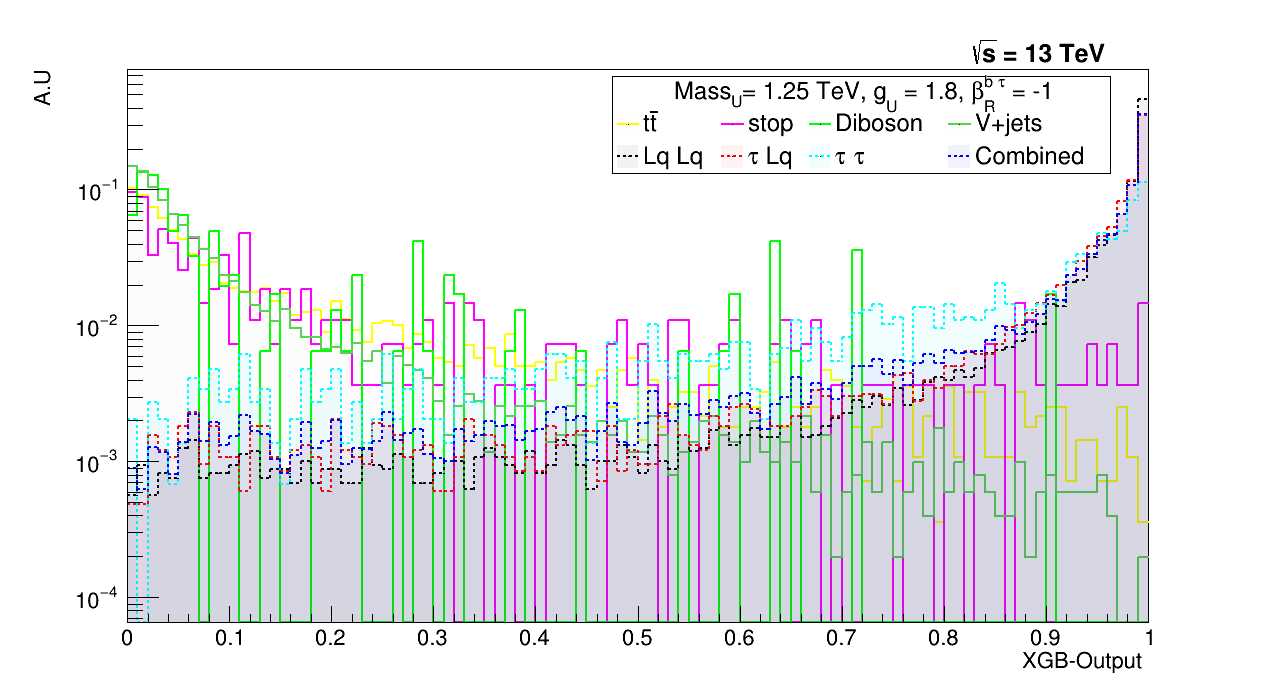

In [14]:
Histos, canvas, legend, Dict_Hist = Overlap_Histos(Signal_Histogram_Dict = histograms_signal, 
                                       Bkg_Histogram_Dict = histograms_bkg, 
                                       channel = "hadronic_dLQ",
                                       Signal_Directory = {'Lq Lq': ['LQ_LQ'], '#tau Lq': ['Tau_LQ'], '#tau #tau': ['Tau_Tau'], 'Combined':  ['LQ_LQ', 'Tau_LQ', 'Tau_Tau']}, 
                                       Bkg_Directory = {'t#bar{t}': ['ttbar'], 'stop': ['stop'], 'Diboson': ['ww', 'wz', 'zz'], 'V+jets': ['w_jets', 'z_jets']}, 
                                       Title_Plot = '', 
                                       Mass = '1250', 
                                       alpha_bkg = 0, 
                                       alpha_signal = 0.05, 
                                       Stack = False, 
                                       Log_Y = True, 
                                       Log_X = False, 
                                       Grid = False)                                                               

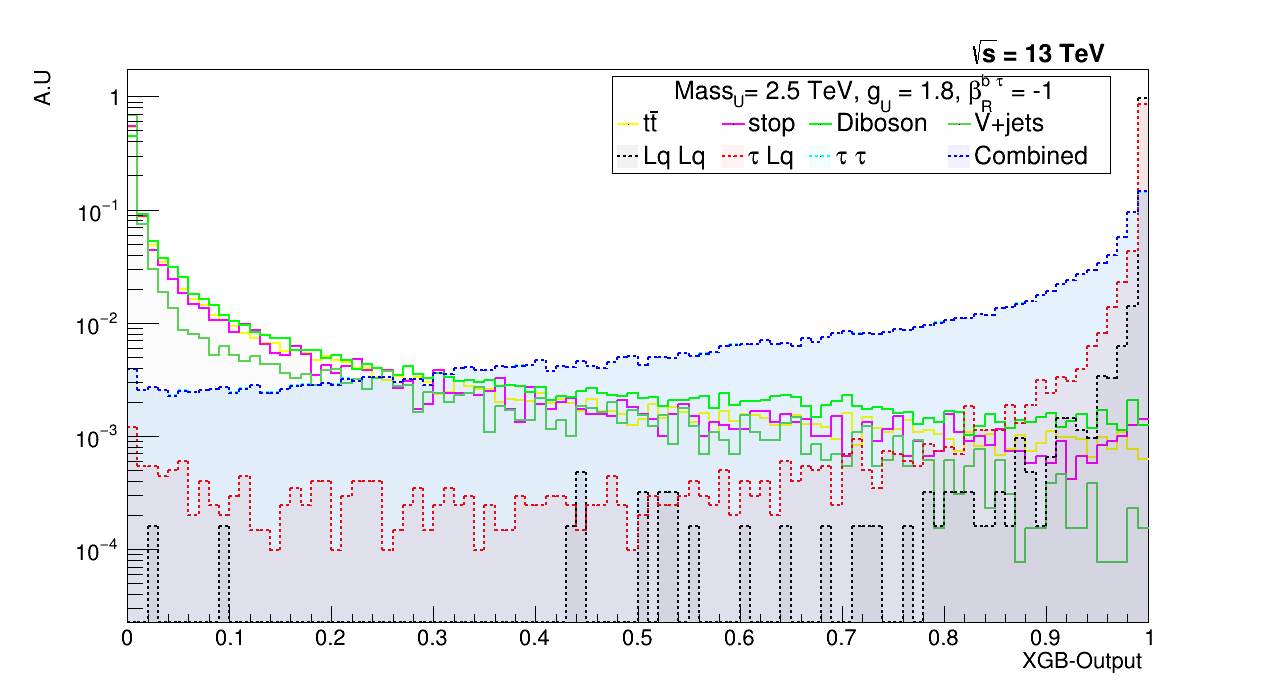

In [15]:
Dict_Hist_by_channel_and_mass = {}

try: os.mkdir('Histograms')
except: pass

for chanel in channels:
    try: os.mkdir(f'Histograms/{chanel}')
    except: pass
    Dict_Hist_by_channel_and_mass[chanel] = {}

    for M in Masses:

        Histos, canvas, legend, Dict_Hist = Overlap_Histos(Signal_Histogram_Dict = histograms_signal, 
                                                           Bkg_Histogram_Dict = histograms_bkg, 
                                                           channel = chanel,
                                                           Signal_Directory = {'Lq Lq': ['LQ_LQ'], '#tau Lq': ['Tau_LQ'], '#tau #tau': ['Tau_Tau'], 'Combined':  ['LQ_LQ', 'Tau_LQ', 'Tau_Tau']}, 
                                                           Bkg_Directory = {'t#bar{t}': ['ttbar'], 'stop': ['stop'], 'Diboson': ['ww', 'wz', 'zz'], 'V+jets': ['w_jets', 'z_jets']}, 
                                                           Title_Plot = '', 
                                                           Mass = M, 
                                                           alpha_bkg = 0, 
                                                           alpha_signal = 0.05, 
                                                           Stack = False, 
                                                           Log_Y = True, 
                                                           Log_X = False, 
                                                           Grid = False,
                                                           Path_folder_to_save = f'Histograms/{chanel}/M{M}')  
        
        Dict_Hist_by_channel_and_mass[chanel][f'M{Mass}'] = Dict_Hist


In [16]:
for chanel in channels:
    for M in Masses:
        Dict_Hist = Dict_Hist_by_channel_and_mass[chanel][f'M{Mass}']
        root_analysis.Write_ROOT_File(f'Histograms/{chanel}/M{M}/All_Histograms.root', Dict_Hist)

In [17]:
ROOT_File_keys = ['Lq Lq', '#tau Lq', '#tau #tau', 'Combined', 't#bar{t}', 'stop', 'Diboson', 'V+jets', 'THStack']

In [18]:
Dict = root_analysis.Read_ROOT_File(f'Histograms/{chanel}/M{M}/All_Histograms.root', ROOT_File_keys)

In [19]:
Dict

{'Lq Lq': <cppyy.gbl.TH1F object at 0x55b54589f790>,
 '#tau Lq': <cppyy.gbl.TH1F object at 0x55b5458ae490>,
 '#tau #tau': <cppyy.gbl.TH1F object at 0x55b5458d3830>,
 'Combined': <cppyy.gbl.TH1F object at 0x55b5458f5800>,
 't#bar{t}': <cppyy.gbl.TH1F object at 0x55b5458cb400>,
 'stop': <cppyy.gbl.TH1F object at 0x55b5458d4220>,
 'Diboson': <cppyy.gbl.TH1F object at 0x55b5458dd9c0>,
 'V+jets': <cppyy.gbl.TH1F object at 0x55b5458d4c20>,
 'THStack': <cppyy.gbl.THStack object at 0x55b5458d5520>}

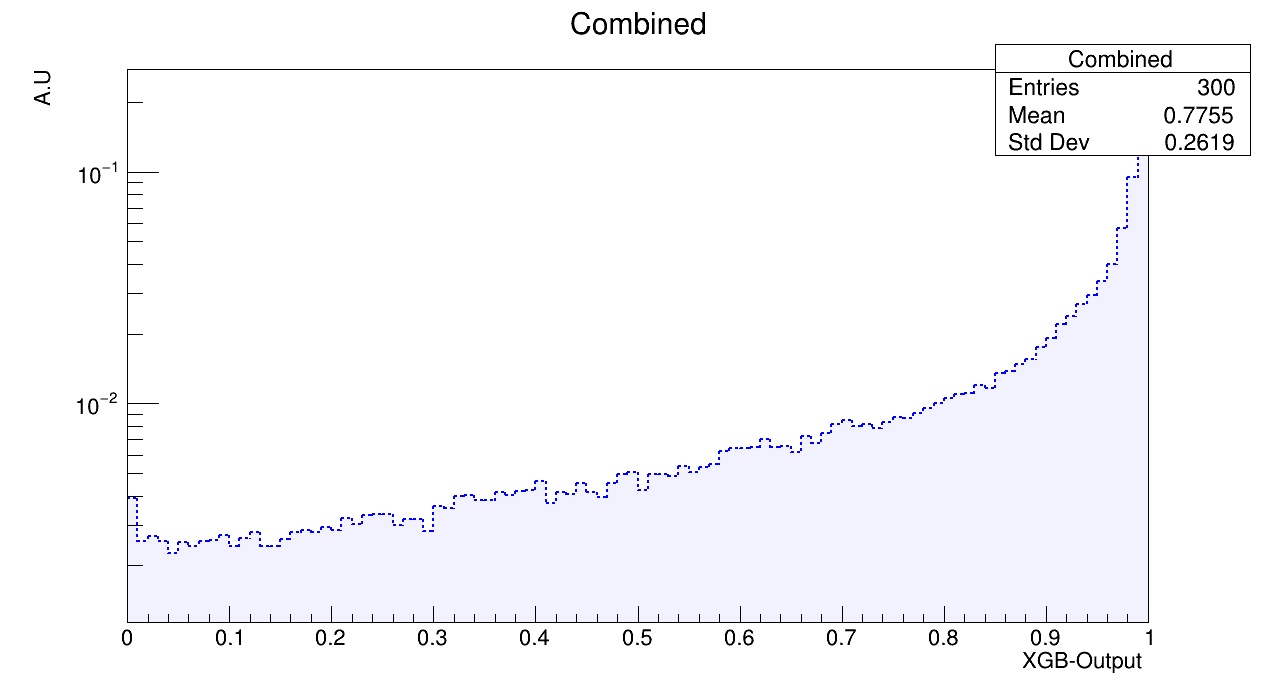

In [20]:
Dict['Combined'].Draw('hist')
canvas.Draw()